# **E-Commerce Transaction: Insights**

---

## 🔍 **Making Sense of the Data**

### 📂 **The Dataset**

In [ ]:
# @title
# Importing the file
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title
# Displaying the data
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/insight_test.csv')
df.head()

,store_code,store_location,order_id,user_id,order_time,delivered_time,products_persona_agg,user_location,total_value_order
0,10011,"-6.168783,106.87677",App-7001192545-1-01,1697711.0,1711249956000,1.711262e+12,"fresh,sembako","-6.1522268,106.8387461",100350.0
1,10011,"-6.168783,106.87677",App-7001121785-1-01,1440401.0,1710144925000,NaN,"household,sembako,snack","-6.1303084,106.854557",251420.0
2,10011,"-6.168783,106.87677",App-7001100711-1-01,1090453.0,1709619150000,1.709623e+12,"fresh,sembako,soft drink and dessert","-6.1838679,106.8657444",139825.0
3,10011,"-6.168783,106.87677",App-7001125693-1-01,1440401.0,1710235525000,1.710243e+12,"household,sembako,snack,soft drink and dessert","-6.1303084,106.854557",258709.0
4,10011,"-6.168783,106.87677",App-4000242981-1-01,34683.0,1710214778000,1.710222e+12,"fresh,snack,soft drink and dessert","-6.1634499,106.92140614",149430.0


In [ ]:
# @title
# Checking the general description of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40722 entries, 0 to 40721
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   store_code            40722 non-null  int64  
 1   store_location        40722 non-null  object 
 2   order_id              40722 non-null  object 
 3   user_id               39877 non-null  float64
 4   order_time            40722 non-null  int64  
 5   delivered_time        27726 non-null  float64
 6   products_persona_agg  40722 non-null  object 
 7   user_location         40722 non-null  object 
 8   total_value_order     40722 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.8+ MB


### ✨ **Feature Engineering**

To better understand the data, the following new columns need to be added:
*   ```delivery_distance```: Distance (in km) estimated based on ```store_location``` and ```user_location```.
*   ```order_to_delivered_in_minutes```: Difference (in minutes) between ```order_time``` and ```delivered_time```.
*   ```delivery_status```: The delivery time is categorized based on its relation to the order date: 'Same Day' indicates delivery occurred on the same day as the order, 'Next Day' means delivery happened the following day, and so on. Cases where no delivery timestamp exists at the time of data retrieval are labeled as 'No Delivery'.



In [ ]:
# @title
# Adding new column: delivery_distance

# Haversine function (vectorized for speed)
def haversine_vectorized(row):
    """
    Calculate distance (km) between 'store_location' and 'user_location'
    in a DataFrame row.
    """
    # Split coordinates into lat/lon and convert to floats
    lat1, lon1 = map(float, row['store_location'].split(','))
    lat2, lon2 = map(float, row['user_location'].split(','))

    # Convert to radians
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return 6371 * 2 * np.arcsin(np.sqrt(a))  # Earth radius = 6371 km

# Apply to DataFrame
df['delivery_distance'] = df.apply(haversine_vectorized, axis=1)

Why Haversine?


> Calculating road distance or travel paths (using routing APIs such as Google Maps or OSRM) would yield the most realistic results. However, these methods are either costly or too time-consuming. Therefore, I opted to use straight-line distance for further analysis. Additionally, I chose the Haversine formula over more accurate alternatives like the Geodesic method, prioritizing computational speed. Since the distances analyzed are mostly within a single city, the potential error introduced by the Haversine formula is negligible and thus sufficient for this purpose.



In [ ]:
df['delivered_time'].dt.time.sort_values().head()

,delivered_time
32146,03:26:26
40586,07:58:17
34082,08:28:49
27655,08:33:33
34029,08:35:12


Given that the five earliest delivery times are after 8 AM, except for two anomalies, it's safe to say that daily deliveries generally start from 8 AM.

In [ ]:
# @title
# Adding new column: order_to_delivered_in_minutes

# Convert timestamp into datetime format
df['order_time'] = pd.to_datetime(df['order_time'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('Asia/Jakarta')
df['delivered_time'] = pd.to_datetime(df['delivered_time'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('Asia/Jakarta')

# Calculate the difference in minutes
df['order_to_delivered_in_minutes'] = (df['delivered_time'] - df['order_time']).dt.total_seconds() / 60

In [ ]:
# @title
# Adding new column: delivery_status

def get_delivery_status(row):
    # Check for null delivered_time first
    if pd.isnull(row['delivered_time']):
        return 'No Delivery'

    # Calculate day difference
    day_diff = (row['delivered_time'].date() - row['order_time'].date()).days

    if day_diff == 0:
        return 'Same Day'
    elif day_diff == 1:
        return 'Next Day'
    elif day_diff == 2:
        return '2 days after order'
    elif day_diff > 2:
        return 'More than 2 days after oder'
    else:
        return 'Invalid'  # Handles cases where delivered_time is before order_time

# Apply the function to create new column
df['delivery_status'] = df.apply(get_delivery_status, axis=1)

# Optional: Convert to categorical for better memory usage and ordering
# status_order = ['Same Day', 'Next Day', '2 days after order', 'More than 2 days after order', 'Invalid', 'No Delivery']
# df['delivery_status'] = pd.Categorical(df['delivery_status'], categories=status_order, ordered=True)

In [ ]:
# @title
# Displaying new data after adding new columns
df.head()

,store_code,store_location,order_id,user_id,order_time,delivered_time,products_persona_agg,user_location,total_value_order,delivery_distance,order_to_delivered_in_minutes,delivery_status
0,10011,"-6.168783,106.87677",App-7001192545-1-01,1697711.0,2024-03-24 10:12:36+07:00,2024-03-24 13:27:17+07:00,"fresh,sembako","-6.1522268,106.8387461",100350.0,4.589097,194.683333,Same Day
1,10011,"-6.168783,106.87677",App-7001121785-1-01,1440401.0,2024-03-11 15:15:25+07:00,NaT,"household,sembako,snack","-6.1303084,106.854557",251420.0,4.932908,NaN,No Delivery
2,10011,"-6.168783,106.87677",App-7001100711-1-01,1090453.0,2024-03-05 13:12:30+07:00,2024-03-05 14:14:50+07:00,"fresh,sembako,soft drink and dessert","-6.1838679,106.8657444",139825.0,2.073453,62.333333,Same Day
3,10011,"-6.168783,106.87677",App-7001125693-1-01,1440401.0,2024-03-12 16:25:25+07:00,2024-03-12 18:31:41+07:00,"household,sembako,snack,soft drink and dessert","-6.1303084,106.854557",258709.0,4.932908,126.266667,Same Day
4,10011,"-6.168783,106.87677",App-4000242981-1-01,34683.0,2024-03-12 10:39:38+07:00,2024-03-12 12:44:49+07:00,"fresh,snack,soft drink and dessert","-6.1634499,106.92140614",149430.0,4.970103,125.183333,Same Day


### ❓ **Missing Values Analysis**
The columns ```user_id``` and ```delivered_time``` have null value. It is important to determine how to handle these null values before going further.



/tmp/ipython-input-30-2646285719.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'distance_group'] = filtered_df['delivery_distance'].apply(


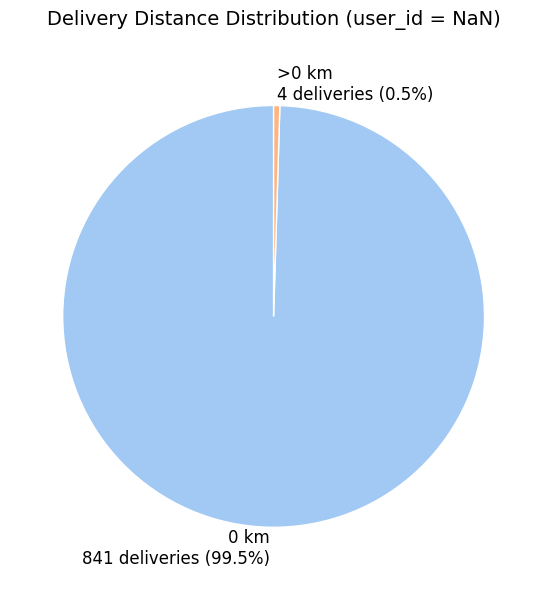

In [ ]:
# @title
import seaborn as sns
import matplotlib.pyplot as plt

# Filter rows where user_id is NaN
filtered_df = df[df['user_id'].isna()]


# Categorize delivery distance
filtered_df.loc[:, 'distance_group'] = filtered_df['delivery_distance'].apply(
    lambda x: '0 km' if x == 0 else '>0 km'
)

# Get counts and calculate percentages
counts = filtered_df['distance_group'].value_counts()
percentages = counts / counts.sum() * 100

# Create labels with counts and percentages
labels = [f'{label}\n{count} deliveries ({percent:.1f}%)'
          for label, count, percent in zip(counts.index, counts, percentages)]

# Create pie chart using Seaborn's color palette
plt.figure(figsize=(8, 6))
sns.set_palette("pastel")  # Use a nice color palette
plt.pie(
    counts,
    labels=labels,
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    textprops={'fontsize': 12}
)

plt.title('Delivery Distance Distribution (user_id = NaN)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [ ]:
# @title
# Checking if there's a case where the delivery distance is 0 km but the user id is not empty
len(df[(df['user_id'].notna()) & (df['delivery_distance'] == 0)])

0

In [ ]:
# @title
filtered_df['delivery_status'].value_counts()

,count
delivery_status,
More than 2 days after oder,667
2 days after order,123
Next Day,46
Same Day,8
No Delivery,1




99.5% of orders with missing user IDs were delivered to the same location as the store they were ordered from, with only four exceptions where deliveries went to different locations. Interestingly, all orders with a 0 km delivery distance also had empty user IDs. While this could suggest transactions where customers purchased directly in-store without registration, the fact that most of these orders were delivered two or more days later makes this scenario unlikely. Given the lack of reliable assumptions to explain these observations, **I excluded all rows with empty user IDs from further analysis to ensure data integrity**.



In [ ]:
# @title
# Excluding all records with empty user ID
df = df[df['user_id'].notna()]
df

,store_code,store_location,order_id,user_id,order_time,delivered_time,products_persona_agg,user_location,total_value_order,delivery_distance,order_to_delivered_in_minutes,delivery_status
0,10011,"-6.168783,106.87677",App-7001192545-1-01,1697711.0,2024-03-24 10:12:36+07:00,2024-03-24 13:27:17+07:00,"fresh,sembako","-6.1522268,106.8387461",100350.0,4.589097,194.683333,Same Day
1,10011,"-6.168783,106.87677",App-7001121785-1-01,1440401.0,2024-03-11 15:15:25+07:00,NaT,"household,sembako,snack","-6.1303084,106.854557",251420.0,4.932908,NaN,No Delivery
2,10011,"-6.168783,106.87677",App-7001100711-1-01,1090453.0,2024-03-05 13:12:30+07:00,2024-03-05 14:14:50+07:00,"fresh,sembako,soft drink and dessert","-6.1838679,106.8657444",139825.0,2.073453,62.333333,Same Day
3,10011,"-6.168783,106.87677",App-7001125693-1-01,1440401.0,2024-03-12 16:25:25+07:00,2024-03-12 18:31:41+07:00,"household,sembako,snack,soft drink and dessert","-6.1303084,106.854557",258709.0,4.932908,126.266667,Same Day
4,10011,"-6.168783,106.87677",App-4000242981-1-01,34683.0,2024-03-12 10:39:38+07:00,2024-03-12 12:44:49+07:00,"fresh,snack,soft drink and dessert","-6.1634499,106.92140614",149430.0,4.970103,125.183333,Same Day
...,...,...,...,...,...,...,...,...,...,...,...,...
40717,40017,"-6.27782,106.71944",App-7001211317-1-01,1706587.0,2024-03-27 08:24:29+07:00,2024-03-27 13:22:53+07:00,snack,"-6.2584863,106.7359841",96900.0,2.822329,298.400000,Same Day
40718,40017,"-6.27782,106.71944",App-7001213347-1-01,1721857.0,2024-03-27 13:44:21+07:00,2024-03-27 14:32:06+07:00,snack,"-6.2584863,106.7359841",106900.0,2.822329,47.750000,Same Day
40719,40017,"-6.27782,106.71944",App-7001211429-1-01,1706655.0,2024-03-27 08:43:38+07:00,2024-03-27 10:21:20+07:00,snack,"-6.2584863,106.7359841",106900.0,2.822329,97.700000,Same Day
40720,40017,"-6.27782,106.71944",App-7001180997-1-01,3391.0,2024-03-22 13:10:56+07:00,2024-03-22 15:57:56+07:00,household,"-6.2615931,106.6991627",259400.0,2.877301,167.000000,Same Day


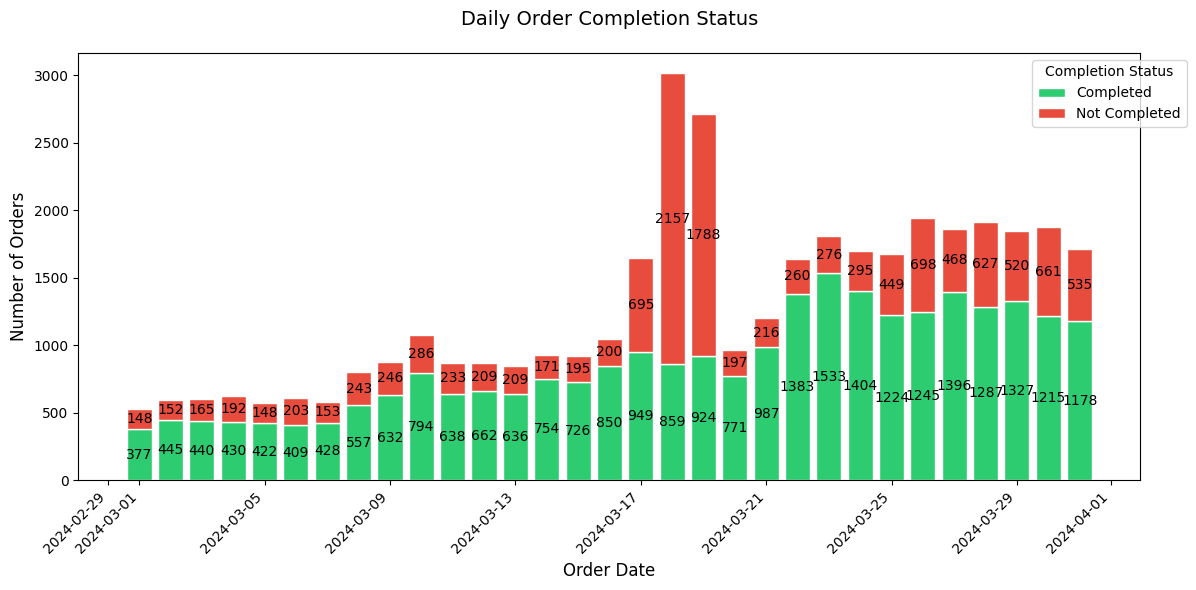

In [ ]:
# @title
# Prepare the data
df['order_date'] = pd.to_datetime(df['order_time']).dt.date
df['completion_status'] = df['delivered_time'].notna().map({
    True: 'Completed',
    False: 'Not Completed'
})

# Get counts - ensuring correct order
status_order = ['Completed', 'Not Completed']
daily_counts = df.groupby(['order_date', 'completion_status']).size().unstack()[status_order]

# Create plot with EXPLICIT color mapping
plt.figure(figsize=(12, 6))
colors = {'Completed': '#2ecc71', 'Not Completed': '#e74c3c'}  # Explicit mapping

# Plot each status separately to guarantee color assignment
bottom = None
for status in status_order:
    plt.bar(
        daily_counts.index,
        daily_counts[status],
        bottom=bottom,
        label=status,
        color=colors[status],
        edgecolor='white',
        width=0.8
    )
    bottom = daily_counts[status] if bottom is None else bottom + daily_counts[status]

# Add value labels
for date in daily_counts.index:
    bottom = 0
    for status in status_order:
        count = daily_counts.loc[date, status]
        if count > 0:
            plt.text(
                date,
                bottom + count/2,
                f'{count}',
                ha='center',
                va='center',
                color='white' if status == 'Delivered' else 'black',
                fontsize=10
            )
            bottom += count

# Formatting
plt.title('Daily Order Completion Status', fontsize=14, pad=20)
plt.xlabel('Order Date', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Completion Status', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [ ]:
# @title
# The most recent delivery timestamp in the dataset indicates that the data was collected on or after this date/time
df['delivered_time'].max()

Timestamp('2024-04-02 10:15:11+0700', tz='Asia/Jakarta')

In [ ]:
# @title
# Checking how many orders were delivered 2 days or more after order
df['delivery_status'].value_counts()

,count
delivery_status,
Same Day,24132
No Delivery,12995
Next Day,2733
2 days after order,15
More than 2 days after oder,2




Given that historically **less than 0.05% of orders were delivered more than two days after ordering**, and considering our data was collected at least 34 hours after the last order timestamp, we can reasonably conclude that orders without a delivered_time will not be completed. These likely represent unfulfilled demand stemming from: order cancellations, abandoned checkouts, or system failures.

Since we cannot definitively determine the exact cause for each case, I will conservatively classify all such instances as **unfulfilled demand**, a key metric we aim to minimize in our operations.






Speaking of delivered_time...

In [ ]:
# @title
# What is the most recent order time among same-day deliveries?
df.loc[df['delivery_status'] == 'Same Day', 'order_time'].dt.time.sort_values(ascending=False).head()

,order_time
8809,20:59:40
14829,20:59:36
6539,20:59:25
18027,20:59:20
40178,20:58:39


Historical data shows that orders placed until 20:59 can still be fulfilled with same-day delivery. Therefore, we can establish Allofresh's service level standard as:

*   Same-day delivery for orders placed before 21:00
*   Next-day delivery for orders placed at 21:00 or later

Any delivery that fails to meet these timelines represents a service performance shortfall on our part.

### 📝 **Summary & Assumptions**
The data consists of E-Commerce transaction records from **March 1st to March 31st, 2024**. The following assumptions were made:

### 📅 Data Scope
- **Last data fetch**: April 2, 2025 (inclusive)

### 📦 Delivery Classification
| Record Type                | Classification          | Action Taken               |
|----------------------------|-------------------------|----------------------------|
| Empty `delivered_time`     | Unfulfilled demand      | Retained for analysis      |
| Empty `user_id`            | Data anomaly            | Excluded from analysis     |

### 🚚 Service Level Agreement
**E-Commerce guarantees:**
- ✅ **Same-day delivery**  
  For orders placed **before 21:00**  
- 🔄 **Next-day delivery**  
  For orders placed **at/after 21:00**

> ‼️ Any deviation from these standards indicates a **service shortfall**

## 🏪 **Stores Performance**

### ⏳ Orders in Queue

In [ ]:
# @title
df_clean = df.copy()

# Build the effective delivered time
df_clean['effective_delivered_time'] = df_clean['delivered_time']

# Mask for orders with missing delivered_time
mask_na = df_clean['delivered_time'].isna()

# Extract hour from order_time
order_hour = df_clean.loc[mask_na, 'order_time'].dt.hour

# For orders placed before 21:00: effective_delivered_time is same day at 21:00
same_day_mask = order_hour < 21
df_clean.loc[mask_na & same_day_mask, 'effective_delivered_time'] = (
    df_clean.loc[mask_na & same_day_mask, 'order_time'].dt.normalize() + pd.Timedelta(hours=21)
)

# For orders placed at or after 21:00: effective_delivered_time is next day at 21:00
next_day_mask = order_hour >= 21
df_clean.loc[mask_na & next_day_mask, 'effective_delivered_time'] = (
    df_clean.loc[mask_na & next_day_mask, 'order_time'].dt.normalize() + pd.Timedelta(days=1, hours=21)
)

In [ ]:
# @title
# +1 event when order enters the queue
starts = df_clean[['store_code', 'order_time']].copy()
starts['time'] = starts['order_time']
starts['change'] = 1
starts = starts[['store_code', 'time', 'change']]

# -1 event when order leaves the queue
ends = df_clean[['store_code', 'effective_delivered_time']].copy()
ends['time'] = ends['effective_delivered_time']
ends['change'] = -1
ends = ends[['store_code', 'time', 'change']]

# Combine and compute orders in queue
events = pd.concat([starts, ends]).sort_values('time').reset_index(drop=True)
events['orders_in_queue'] = events.groupby('store_code')['change'].cumsum()
events['date'] = events['time'].dt.date

# Compute peak per day
peak_per_day = (
    events.groupby(['store_code', 'date'])['orders_in_queue']
    .max()
    .reset_index(name='peak_orders_in_queue')
)

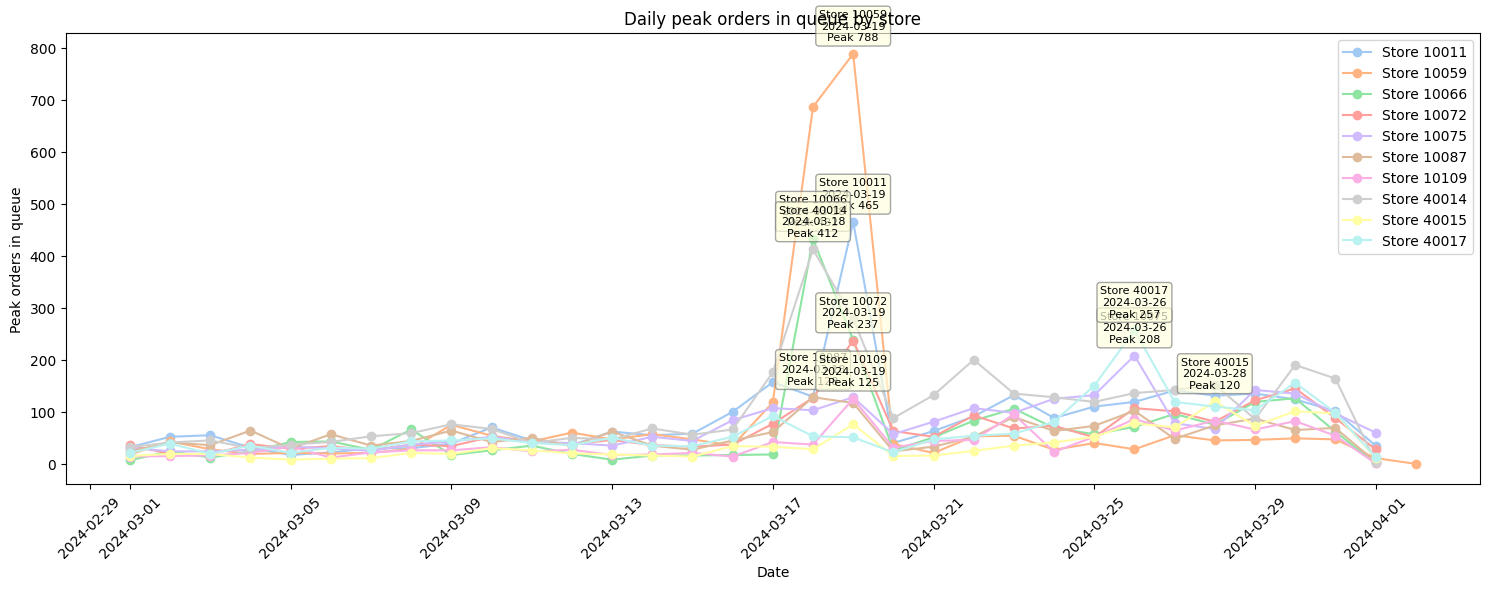

In [ ]:
# @title
plt.figure(figsize=(15, 6))

for store, data in peak_per_day.groupby('store_code'):
    plt.plot(data['date'], data['peak_orders_in_queue'], marker='o', label=f'Store {store}')

    # Annotate highest peak for this store
    max_row = data.loc[data['peak_orders_in_queue'].idxmax()]
    max_date = max_row['date']
    max_value = max_row['peak_orders_in_queue']
    annotation = f"Store {store}\n{max_date}\nPeak {max_value}"

    plt.annotate(annotation,
                 xy=(max_date, max_value),
                 xytext=(0, 8),
                 textcoords='offset points',
                 ha='center', va='bottom',
                 fontsize=8, color='black',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', edgecolor='gray', alpha=0.7))

plt.title('Daily peak orders in queue by store')
plt.xlabel('Date')
plt.ylabel('Peak orders in queue')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Given the visualization above, it's evident there was an anomaly on March 18th and 19th. This sudden spike in orders may have been caused by a special event or promotional activity. Consequently, records from these two days have been excluded from subsequent analysis.

In [ ]:
# @title
# Remove anomalies
excluded_dates = [pd.to_datetime('2024-03-18').date(), pd.to_datetime('2024-03-19').date()]
events = events[~events['date'].isin(excluded_dates)].copy()

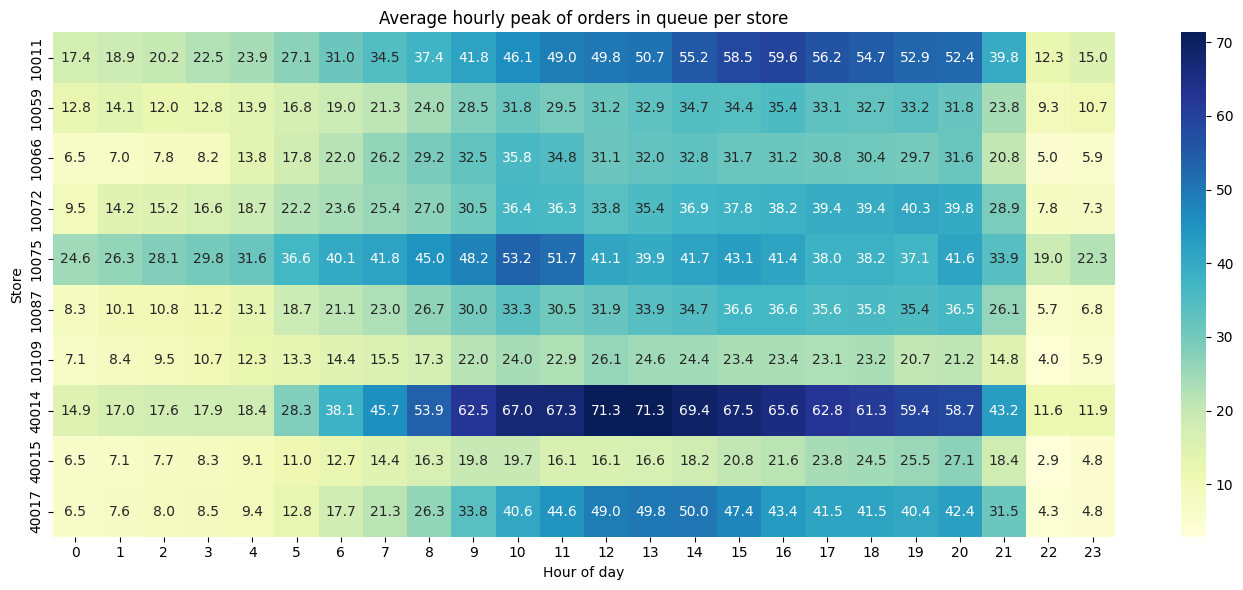

In [ ]:
# @title
# ------------------------------------------------------------
# Build hourly grid
# ------------------------------------------------------------
from pandas import date_range

min_time = events['time'].min().floor('h')
max_time = events['time'].max().ceil('h')
hourly_times = pd.date_range(start=min_time, end=max_time, freq='h')
stores = events['store_code'].unique()

grid = pd.MultiIndex.from_product(
    [stores, hourly_times],
    names=['store_code', 'time']
).to_frame(index=False)

# ------------------------------------------------------------
# Compute orders in queue at each hour using merge_asof
# ------------------------------------------------------------
events_sorted = events.sort_values(['store_code', 'time'])

hourly_counts = []

for store in stores:
    store_events = events_sorted[events_sorted['store_code'] == store][['time', 'orders_in_queue']].sort_values('time')
    store_grid = grid[grid['store_code'] == store].sort_values('time')

    merged = pd.merge_asof(store_grid, store_events, on='time', direction='backward')
    merged['orders_in_queue'] = merged['orders_in_queue'].fillna(0)

    hourly_counts.append(merged)

hourly_counts_df = pd.concat(hourly_counts, ignore_index=True)

# ------------------------------------------------------------
# Compute average peak by hour of day
# ------------------------------------------------------------
hourly_counts_df['hour'] = hourly_counts_df['time'].dt.hour

avg_hourly_peak = (
    hourly_counts_df.groupby(['store_code', 'hour'])['orders_in_queue']
    .mean()
    .reset_index(name='avg_peak_orders_in_queue')
)

# ------------------------------------------------------------
# Heatmap
# ------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

heat_data = avg_hourly_peak.pivot(
    index='store_code', columns='hour', values='avg_peak_orders_in_queue'
)

plt.figure(figsize=(14, 6))
sns.heatmap(heat_data, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Average hourly peak of orders in queue per store')
plt.xlabel('Hour of day')
plt.ylabel('Store')
plt.tight_layout()
plt.show()

In [ ]:
# @title
import folium

# Filter only delivered orders
delivered_df = df[df['delivered_time'].notna()].copy()

# Aggregate total order value by store
store_orders = delivered_df.groupby(['store_code', 'store_location']).agg(
    total_order_value=('total_value_order', 'sum')
).reset_index()

# Split location and convert to millions
store_orders[['lat', 'lon']] = store_orders['store_location'].str.split(',', expand=True).astype(float)
store_orders['total_order_value_millions'] = (store_orders['total_order_value'] / 1e6).round(1)

# Create base map
map_center = [store_orders['lat'].mean(), store_orders['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Normalize sizes
max_order = store_orders['total_order_value_millions'].max()
min_order = store_orders['total_order_value_millions'].min()
size_factor = 30

# Rupiah formatter
def format_rupiah(value):
    return f"Rp {value:,.1f}jt".replace(",", ".")

# Add circle markers only
for idx, row in store_orders.iterrows():
    circle_size = 5 + (row['total_order_value_millions'] - min_order) / (max_order - min_order) * size_factor

    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=circle_size,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        popup=folium.Popup(
            f"""
            <b>Store:</b> {row['store_code']}<br>
            <b>Total Orders:</b> {format_rupiah(row['total_order_value_millions'])}<br>
            <b>Location:</b> {row['lat']:.5f}, {row['lon']:.5f}
            """,
            max_width=250
        ),
        tooltip=f"Click for details"
    ).add_to(m)

# Add legend
legend_html = f'''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 180px; height: 90px;
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding: 5px">
    <b>Circle Size Legend</b><br>
    Small: {format_rupiah(min_order)}<br>
    Large: {format_rupiah(max_order)}
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Display map
m

In [ ]:
# -----------------------------------------
# 0. Setup Jakarta timezone
# -----------------------------------------
jakarta = 'Asia/Jakarta'

# Ensure datetime columns are timezone-aware
df.loc[:, 'order_time'] = pd.to_datetime(df['order_time']).dt.tz_convert(jakarta)
df.loc[:, 'delivered_time'] = pd.to_datetime(df['delivered_time']).dt.tz_convert(jakarta)

# -----------------------------------------
# 1. Filter out March 18th and 19th, 2024
# -----------------------------------------
excluded_dates = [
    pd.Timestamp('2024-03-18', tz=jakarta).date(),
    pd.Timestamp('2024-03-19', tz=jakarta).date()
]

df = df[~df['order_time'].dt.date.isin(excluded_dates)].copy()

# -----------------------------------------
# 2. Create hour_group
# -----------------------------------------
def assign_hour_group(row):
    hour = row['order_time'].hour
    if 21 <= hour or hour < 8:
        group_date = row['order_time'].date()
        if hour < 8:
            group_date = (row['order_time'] - pd.Timedelta(days=1)).date()
        return pd.Timestamp(f"{group_date} 21:00", tz=jakarta)
    else:
        return row['order_time'].replace(minute=0, second=0, microsecond=0)

df.loc[:, 'hour_group'] = df.apply(assign_hour_group, axis=1)

# -----------------------------------------
# 3. Compute completion time with SLA rules
# -----------------------------------------
def compute_completion_time(row):
    if pd.isna(row['delivered_time']):
        return np.nan
    order_hour = row['order_time'].hour
    if 21 <= order_hour or order_hour < 8:
        if order_hour < 8:
            next_8am = row['order_time'].replace(hour=8, minute=0, second=0, microsecond=0)
        else:
            next_day = row['order_time'] + pd.Timedelta(days=1)
            next_8am = next_day.replace(hour=8, minute=0, second=0, microsecond=0)
        return (row['delivered_time'] - next_8am).total_seconds() / 60
    else:
        return (row['delivered_time'] - row['order_time']).total_seconds() / 60

df.loc[:, 'completion_time'] = df.apply(compute_completion_time, axis=1)

# -----------------------------------------
# 4. Compute queue_end_time based on your rules
# -----------------------------------------
def compute_queue_end(row):
    if not pd.isna(row['delivered_time']):
        return row['delivered_time']
    hour = row['order_time'].hour
    if 8 <= hour < 21:
        # ends at end of same day
        return pd.Timestamp(f"{row['order_time'].date()} 23:59:59", tz=jakarta)
    else:
        # ends at end of next day
        next_day = row['order_time'] + pd.Timedelta(days=1)
        return pd.Timestamp(f"{next_day.date()} 23:59:59", tz=jakarta)

df.loc[:, 'queue_end_time'] = df.apply(compute_queue_end, axis=1)

# -----------------------------------------
# 5. Aggregate basic stats
# -----------------------------------------
grouped = df.groupby(['store_code', 'hour_group'])

agg_df = grouped.agg(
    orders_count=('order_time', 'count'),
    completed_orders_count=('delivered_time', lambda x: x.notna().sum()),
    total_distance=('delivery_distance', lambda x: x.sum() * 2),
    total_distance_delivered=('delivery_distance', lambda x: x[df.loc[x.index, 'delivered_time'].notna()].sum() * 2),
    total_distance_not_delivered=('delivery_distance', lambda x: x[df.loc[x.index, 'delivered_time'].isna()].sum() * 2)
).reset_index()

agg_df.loc[:, 'completion_rate'] = agg_df['completed_orders_count'] / agg_df['orders_count']

# -----------------------------------------
# 6. Compute avg_completion_time (only valid SLAs)
# -----------------------------------------
def valid_for_avg(row):
    if pd.isna(row['delivered_time']):
        return False
    return (row['delivered_time'] - row['order_time']) <= pd.Timedelta(days=1)

df.loc[:, 'valid_completion'] = df.apply(valid_for_avg, axis=1)

avg_completion = df[df['valid_completion']].groupby(['store_code', 'hour_group'])['completion_time'].mean().reset_index()
avg_completion.rename(columns={'completion_time': 'avg_completion_time'}, inplace=True)

agg_df = agg_df.merge(avg_completion, on=['store_code', 'hour_group'], how='left')

# -----------------------------------------
# 7. Compute avg_completion_speed
# -----------------------------------------
total_completion_time = df[df['valid_completion']].groupby(['store_code', 'hour_group'])['completion_time'].sum().reset_index()
total_completion_time.rename(columns={'completion_time': 'total_completion_time'}, inplace=True)

agg_df = agg_df.merge(total_completion_time, on=['store_code', 'hour_group'], how='left')
agg_df.loc[:, 'avg_completion_speed'] = agg_df['total_completion_time'] / agg_df['total_distance_delivered']
agg_df.drop(columns='total_completion_time', inplace=True)

# -----------------------------------------
# 8. Compute peak_orders_in_queue based on queue_end_time
# -----------------------------------------
time_range = pd.date_range(
    start=df['order_time'].min().floor('h'),
    end=df['queue_end_time'].max().ceil('h'),
    freq='h',
    tz=jakarta
)

records = []
for (store,), sub in df.groupby(['store_code']):
    for t in time_range:
        in_queue = sub[(sub['order_time'] <= t) & (sub['queue_end_time'] > t)]
        records.append({
            'store_code': store,
            'hour': t,
            'orders_in_queue': len(in_queue)
        })

queue_df = pd.DataFrame(records)

# map back to hour_group
def hour_group_for_queue(t):
    hour = t.hour
    if 21 <= hour or hour < 8:
        group_date = t.date()
        if hour < 8:
            group_date = (t - pd.Timedelta(days=1)).date()
        return pd.Timestamp(f"{group_date} 21:00", tz=jakarta)
    else:
        return t.replace(minute=0, second=0, microsecond=0)

queue_df.loc[:, 'hour_group'] = queue_df['hour'].apply(hour_group_for_queue)

# compute peak
peak_queue = queue_df.groupby(['store_code', 'hour_group'])['orders_in_queue'].max().reset_index()
peak_queue.rename(columns={'orders_in_queue': 'peak_orders_in_queue'}, inplace=True)

# merge
agg_df = agg_df.merge(peak_queue, on=['store_code', 'hour_group'], how='left')

# -----------------------------------------
# 9. Final result
# -----------------------------------------
agg_df = agg_df[['store_code', 'hour_group', 'orders_count', 'completed_orders_count',
                 'completion_rate', 'avg_completion_time',
                 'total_distance', 'total_distance_delivered', 'total_distance_not_delivered',
                 'avg_completion_speed', 'peak_orders_in_queue']]

agg_df

,store_code,hour_group,orders_count,completed_orders_count,completion_rate,avg_completion_time,total_distance,total_distance_delivered,total_distance_not_delivered,avg_completion_speed,peak_orders_in_queue
0,10011,2024-02-29 21:00:00+07:00,22,6,0.272727,260.333333,215.047542,42.411667,172.635875,36.829489,18
1,10011,2024-03-01 08:00:00+07:00,2,2,1.000000,217.808333,21.471842,21.471842,0.000000,20.287810,22
2,10011,2024-03-01 09:00:00+07:00,5,1,0.200000,146.133333,54.114821,10.827275,43.287546,13.496779,24
3,10011,2024-03-01 10:00:00+07:00,3,2,0.666667,186.325000,17.918234,11.626477,6.291757,32.051842,29
4,10011,2024-03-01 12:00:00+07:00,2,2,1.000000,142.408333,15.943895,15.943895,0.000000,17.863682,26
...,...,...,...,...,...,...,...,...,...,...,...
3840,40017,2024-03-31 16:00:00+07:00,8,8,1.000000,240.889583,65.328587,65.328587,0.000000,29.498827,51
3841,40017,2024-03-31 18:00:00+07:00,1,1,1.000000,64.000000,6.362476,6.362476,0.000000,10.058977,50
3842,40017,2024-03-31 19:00:00+07:00,4,4,1.000000,63.870833,40.473768,40.473768,0.000000,6.312319,42
3843,40017,2024-03-31 20:00:00+07:00,11,2,0.181818,408.366667,109.687856,15.314868,94.372988,53.329441,41


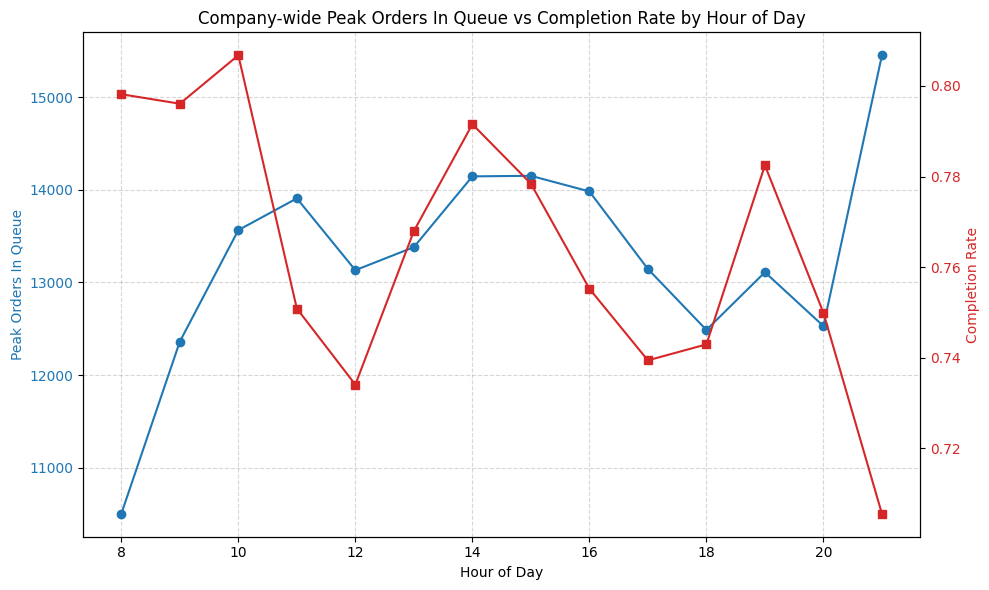

In [ ]:
# -----------------------------------------
# Prepare data by extracting hour
# -----------------------------------------
agg_df['hour_of_day'] = agg_df['hour_group'].dt.hour

# -----------------------------------------
# Aggregate by hour_of_day across all stores & days
# -----------------------------------------
agg_hour = agg_df.groupby('hour_of_day').agg({
    'peak_orders_in_queue': 'sum',
    'completion_rate': 'mean'  # you can also try 'median' if noisy
}).reset_index()

# -----------------------------------------
# Plot line chart
# -----------------------------------------
fig, ax1 = plt.subplots(figsize=(10,6))

color1 = 'tab:blue'
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Peak Orders In Queue', color=color1)
ax1.plot(agg_hour['hour_of_day'], agg_hour['peak_orders_in_queue'], color=color1, marker='o', label='Peak Orders In Queue')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle='--', alpha=0.5)

# Second y-axis for completion_rate
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Completion Rate', color=color2)
ax2.plot(agg_hour['hour_of_day'], agg_hour['completion_rate'], color=color2, marker='s', label='Completion Rate')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Company-wide Peak Orders In Queue vs Completion Rate by Hour of Day')
plt.tight_layout()
plt.show()

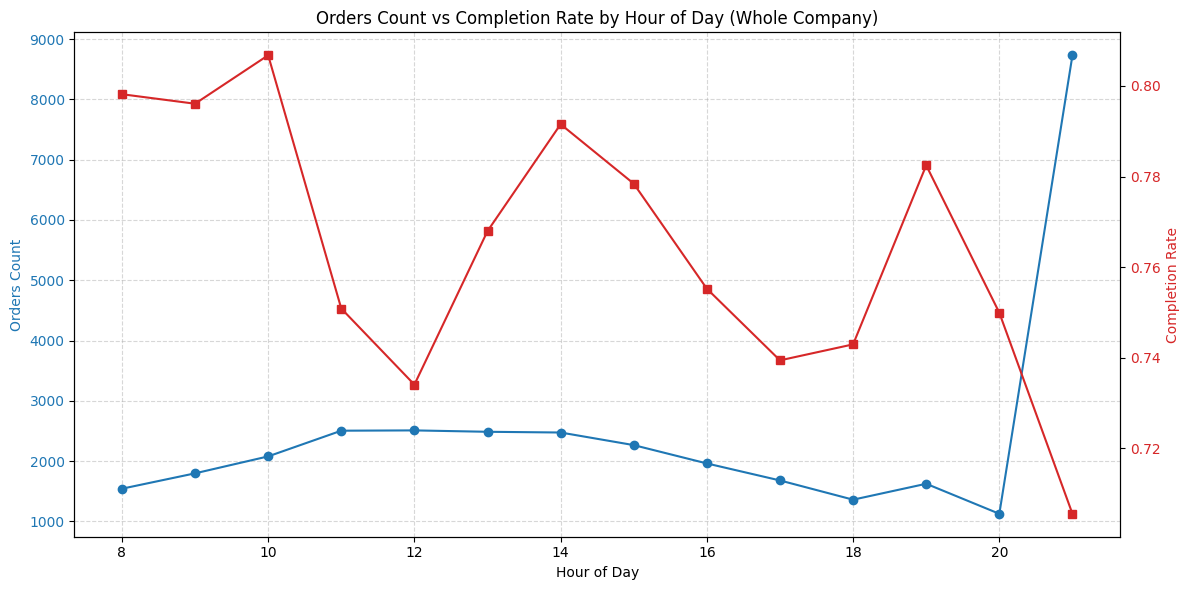

In [ ]:
# -----------------------------------------
# Prepare aggregated data across all stores
# -----------------------------------------
agg_hour = agg_df.groupby('hour_of_day').agg({
    'orders_count': 'sum',
    'completion_rate': 'mean'
}).reset_index()

# -----------------------------------------
# Plot line chart
# -----------------------------------------
fig, ax1 = plt.subplots(figsize=(12,6))

color1 = 'tab:blue'
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Orders Count', color=color1)
ax1.plot(agg_hour['hour_of_day'], agg_hour['orders_count'], color=color1, marker='o', label='Orders Count')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle='--', alpha=0.5)

# Second y-axis for completion_rate
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Completion Rate', color=color2)
ax2.plot(agg_hour['hour_of_day'], agg_hour['completion_rate'], color=color2, marker='s', label='Completion Rate')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Orders Count vs Completion Rate by Hour of Day (Whole Company)')
plt.tight_layout()
plt.show()

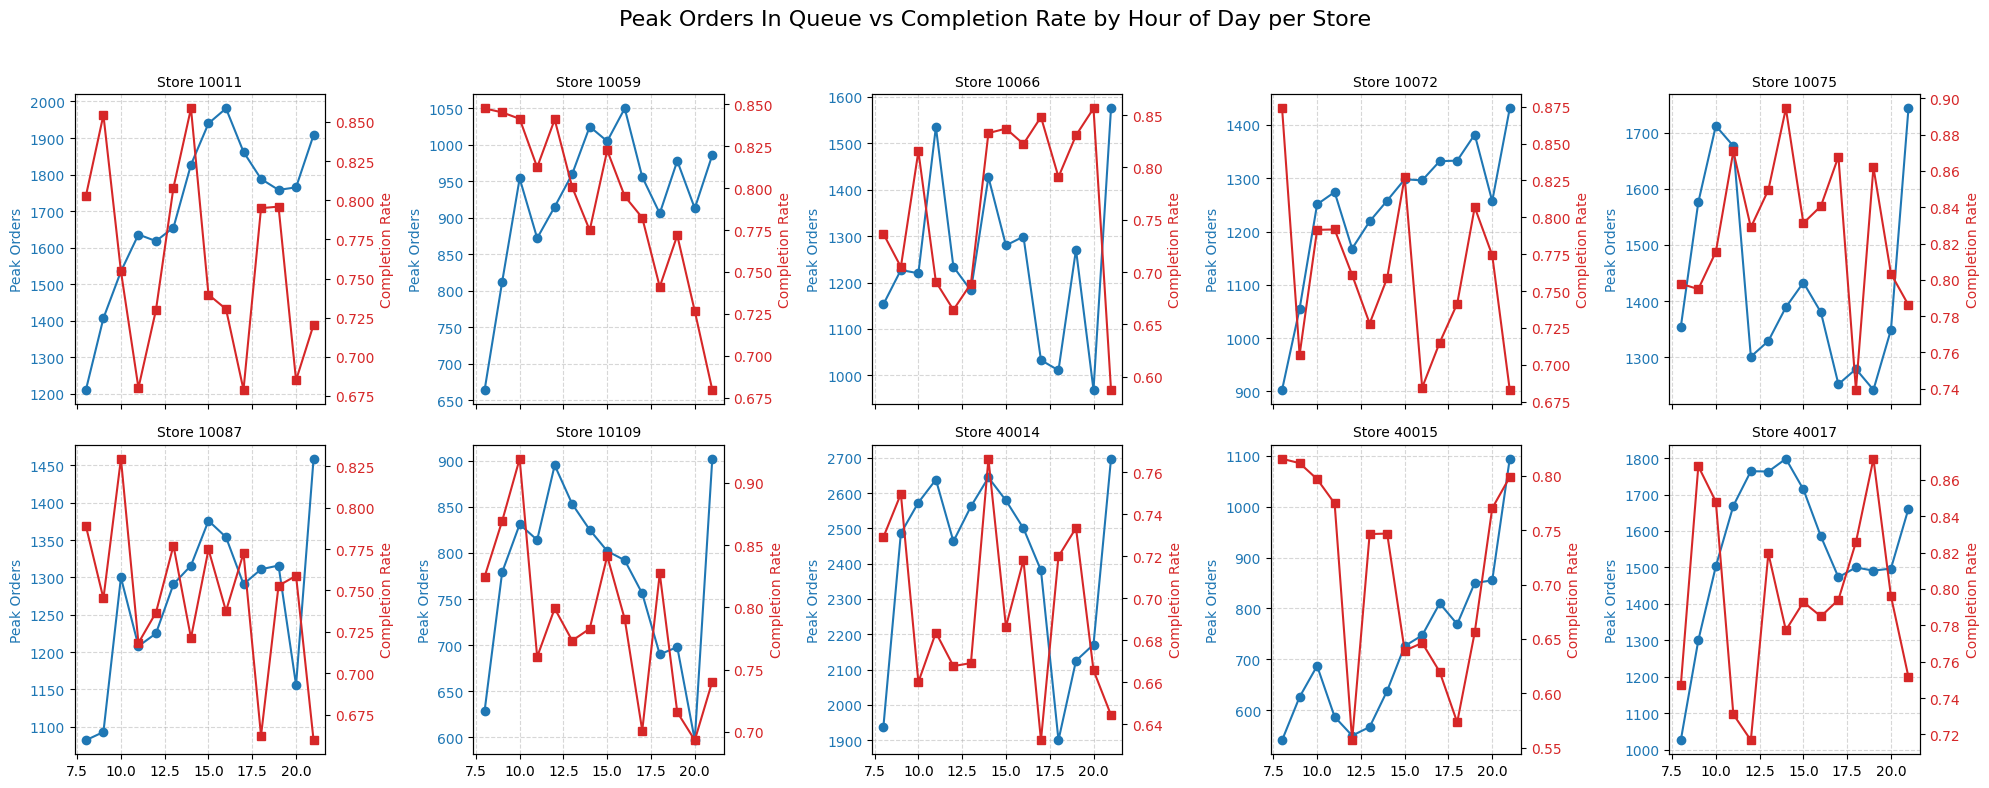

In [ ]:
# -----------------------------------------
# Prepare data
# -----------------------------------------
stores = agg_df['store_code'].unique()
n_cols = 5
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8), sharex=True)
axes = axes.flatten()

# -----------------------------------------
# Plot each store
# -----------------------------------------
for i, store in enumerate(stores):
    ax1 = axes[i]
    store_data = agg_df[agg_df['store_code'] == store]
    agg_hour = store_data.groupby('hour_of_day').agg({
        'peak_orders_in_queue': 'sum',
        'completion_rate': 'mean'
    }).reset_index()

    color1 = 'tab:blue'
    ax1.plot(agg_hour['hour_of_day'], agg_hour['peak_orders_in_queue'], color=color1, marker='o')
    ax1.set_ylabel('Peak Orders', color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_title(f"Store {store}", fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.5)

    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.plot(agg_hour['hour_of_day'], agg_hour['completion_rate'], color=color2, marker='s')
    ax2.set_ylabel('Completion Rate', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

# Hide any empty subplots if <10 stores
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Peak Orders In Queue vs Completion Rate by Hour of Day per Store', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()